# Model 2: Baseline Model with Stemming + SVM

Set up a basic pipeline using manual text preprocessing and Logistic Regression.

## 🔧 Steps:
1. Import Librairies and load data (Assign columns name)

2. Preprocessing:

    - Remove punctuation and digits

    - Tokenize

    - Remove stopwords

    - Stemming (using NLTK’s PorterStemmer)

    - Join tokens back into a string

3. Vectorization:

    - TF-IDF Vectorization

4. Model:

    - SVM Model

5. Evaluation:

    - Accuracy, confusion matrix, classification report

6. Prediction for Testing Data

##  ✅ Purpose:
Establish a working pipeline and baseline score (~70-80% accuracy is expected here).

## 1. Import Librairies and load data

In [24]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [25]:
data = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
data.reset_index(drop=True, inplace=True)  # optional

data.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [26]:
data = data.drop_duplicates(subset='title')
print("Duplicate titles:", data['title'].duplicated().sum())

Duplicate titles: 0


## 2. Preprocessing:
* StopWords
* Tokenization
* Stemmer and Lemmatizer
* Removing Special Characters and Digits

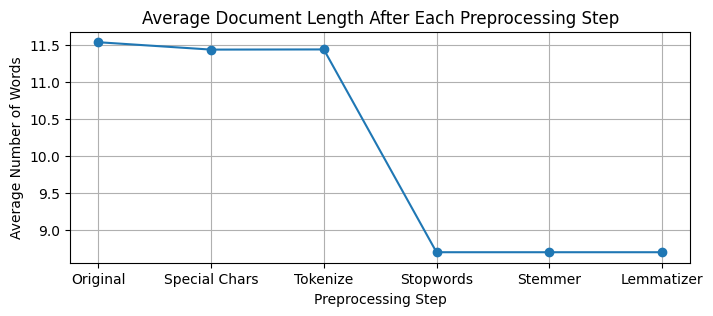

In [27]:
# Step 1: For plotting (intermediate results)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
special_removed = data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [28]:
# Step 2: For final clean data (single function)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.lower() not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

data["clean_title"] = data["title"].apply(preprocess_text)

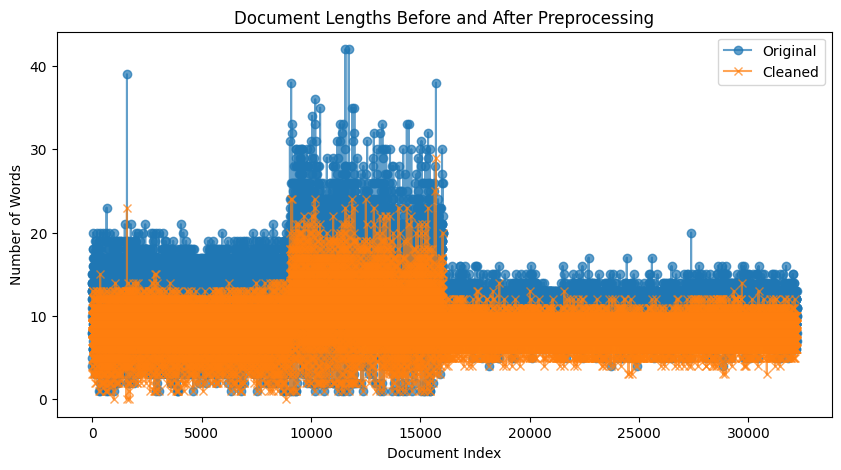

In [29]:
# Calculate document lengths before and after preprocessing
orig_lengths = data['title'].apply(lambda x: len(x.split()))
clean_lengths = data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

## 3. Train split and Vectorization:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data["clean_title"], data["label"], test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
x_tfidf = tfidf_vectorizer.fit_transform(data['clean_title'])

# x_tfidf is a sparse matrix of TF-IDF features
print(x_tfidf.shape) 
print("TF-IDF Representation:\n", x_tfidf.toarray())

(32206, 15267)
TF-IDF Representation:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


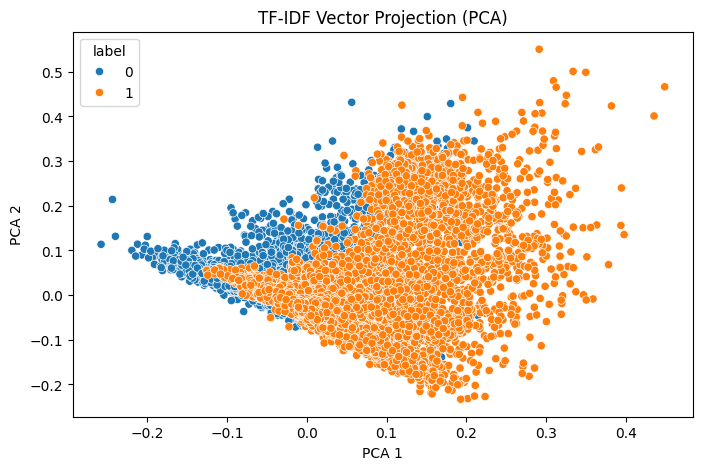

In [31]:
import seaborn as sns
from sklearn.decomposition import PCA

# Create PCA object and fit_transform
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_tfidf.toarray())

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['label'], palette='tab10')
plt.title('TF-IDF Vector Projection (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## 4. LinearSVC Regression Model:

In [32]:
# Model training
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Vectorize the training data using the existing tfidf_vectorizer
X_train_vec = tfidf_vectorizer.transform(X_train)

# Train SVM model
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train_vec, y_train)


LinearSVC()

## 5. Evaluation:

In [33]:
# Vectorize the test data using the same tfidf_vectorizer as training
X_test_vec = tfidf_vectorizer.transform(X_test)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_vec)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9335610058987892
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3233
           1       0.93      0.94      0.93      3209

    accuracy                           0.93      6442
   macro avg       0.93      0.93      0.93      6442
weighted avg       0.93      0.93      0.93      6442



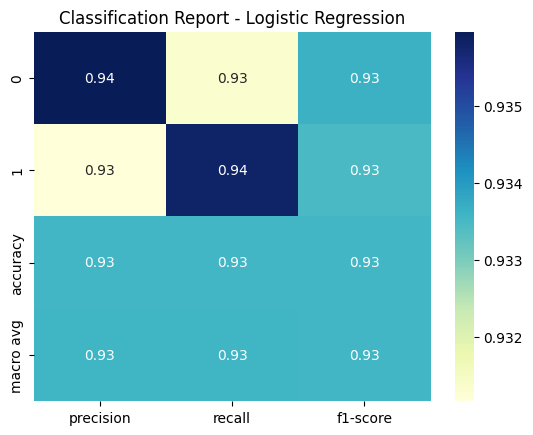

In [34]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred_svm, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report - Logistic Regression')
plt.show()

## 6. Confusion Matrix Plot:

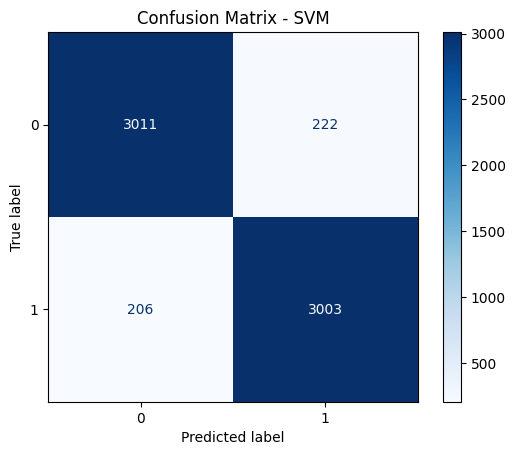

In [35]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_vec, y_test, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()


## 7 Testing Data

In [36]:
predicted_data = pd.read_csv('Data/testing_data_lowercase_nolabels.csv')
#new_data = new_testing_data.to_csv('Data/Predicted_Data.csv', index=False)
#predicted_data = pd.read_csv('data/Predicted_Data.csv')

In [37]:
# Read the predicted data as a CSV (tab-separated) and assign column names
predicted_data = pd.read_csv('Data/testing_data_lowercase_nolabels.csv', sep='\t', header=None, names=["label", "title"])
# Check the result
print(predicted_data.head())

  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


## PreProcessing Testing Data

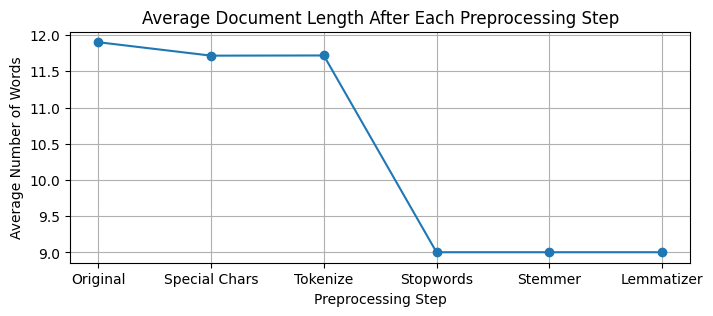

In [38]:
stop_words = set(stopwords.words('english'))
predicted_data['title'] = predicted_data['title'].astype(str)

special_removed = predicted_data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    predicted_data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [39]:
# Step 2: For final clean data (single function)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.lower() not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

predicted_data["clean_title"] = predicted_data["title"].apply(preprocess_text)

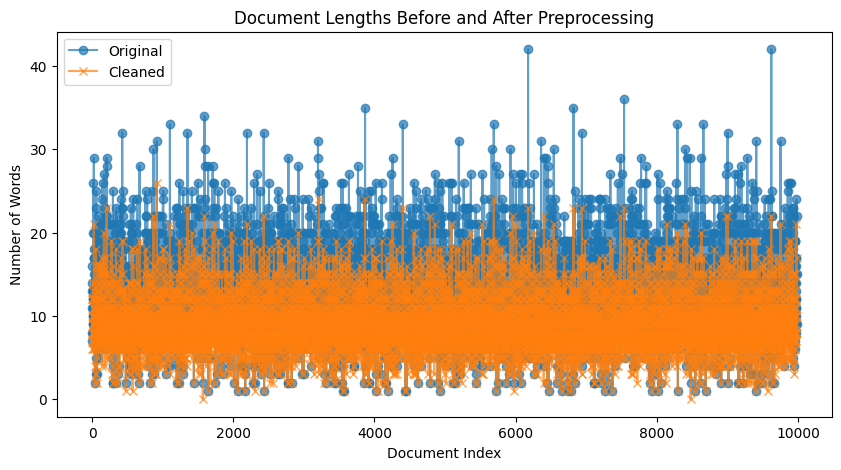

In [40]:
# Calculate document lengths before and after preprocessing
orig_lengths = predicted_data['title'].apply(lambda x: len(x.split()))
clean_lengths = predicted_data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

## Testing Data with Trained Model

In [41]:
# 1. Vectorize the clean titles using the same vectorizer as training
X_real_vec = tfidf_vectorizer.transform(predicted_data["clean_title"])

# 2. Predict labels using the trained SVM model
predicted_labels = svm_model.predict(X_real_vec)

# 3. Add predictions to the DataFrame (optional, for plotting)
predicted_data["predicted_label"] = predicted_labels

# Optional: Show a sample
print(predicted_data.head())

  label                                              title  \
0     2  copycat muslim terrorist arrested with assault...   
1     2  wow! chicago protester caught on camera admits...   
2     2   germany's fdp look to fill schaeuble's big shoes   
3     2  mi school sends welcome back packet warning ki...   
4     2  u.n. seeks 'massive' aid boost amid rohingya '...   

                                         clean_title  predicted_label  
0     copycat muslim terrorist arrest assault weapon                0  
1  wow chicago protest caught camera admit violen...                0  
2            germani fdp look fill schaeubl big shoe                0  
3  mi school send welcom back packet warn kid wea...                0  
4  un seek massiv aid boost amid rohingya emerg w...                1  



## Visualization of Predicted Values

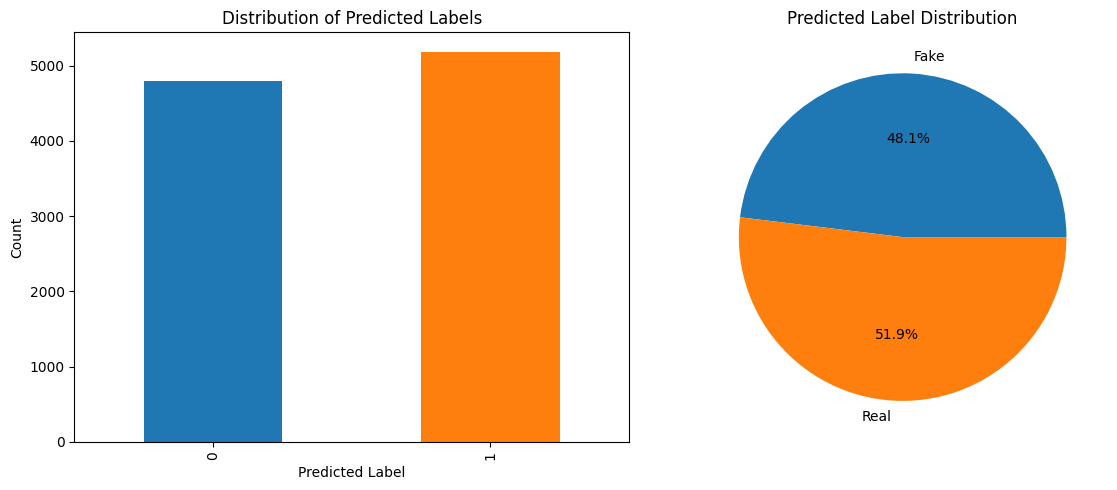

In [42]:
# Convert predictions to Series
pred_series = pd.Series(predicted_labels)
bar_colors = ['#1f77b4', '#ff7f0e']  # Example: blue for 0, orange for 1

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart (no change needed)
pred_series.value_counts().sort_index().plot(
    kind='bar',
    color=bar_colors,
    ax=axes[0]
)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Predicted Labels')

# Pie chart (let pandas use the correct labels)
pred_series.value_counts().sort_index().plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=pred_series.value_counts().sort_index().index.map({0: 'Fake', 1: 'Real'}),
    colors=bar_colors,
    ax=axes[1]
)
axes[1].set_title('Predicted Label Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()